In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import ( basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz,destroy,
                   tensor)
from qutip.solver import heom
from scipy.integrate import quad
%matplotlib inline

In [2]:
# Set the system parameters
N = 3
g=1
J=5*g
# initial state
state_list = [basis(2, 1)] + [basis(2, 0)] * (N - 1)
psi0 = tensor(state_list)

# Interaction coefficients
#Jx = 0.2 * np.pi * np.ones(N)
#Jy = 0.2 * np.pi * np.ones(N)
#Jz = 0.2 * np.pi * np.ones(N)

sx_list, sy_list, sz_list = [], [], []
for i in range(N):
    op_list = [qeye(2)] * N
    op_list[i] = sigmax()
    sx_list.append(tensor(op_list))
    op_list[i] = sigmay()
    sy_list.append(tensor(op_list))
    op_list[i] = sigmaz()
    sz_list.append(tensor(op_list))

# Hamiltonian - Energy splitting terms
H = 0
for i in range(N):
    H += g* sz_list[i]

for n in range(N - 1):
    H += -J* sx_list[n] * sx_list[n + 1]
    #H += -0.5 * Jy[n] * sy_list[n] * sy_list[n + 1]
    #H += -0.5 * Jz[n] * sz_list[n] * sz_list[n + 1]

In [3]:
E01=H.eigenenergies()[2]-H.eigenenergies()[0]# Raise this question about the paper 
gamma=3.8*g
w0=1.2*E01
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2 +0j)
lam=1.15*g*np.sqrt(Omega)

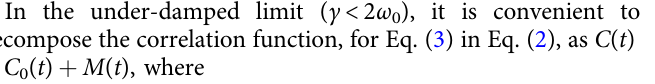

below I just check that the condition is satisfied

In [4]:
2*w0>gamma

True

In [5]:
gamma

3.8

In [6]:
Q=sz_list[-1]+ 1.1*sy_list[-1]+0.9*sz_list[-1]

Zero temperature Pseudomode fitting

In [7]:
def _matsubara_zero_integrand(t, coup_strength, bath_broad, bath_freq):
    """
    Integral for the zero temperature Matsubara exponentials.
    """
    lam = coup_strength
    gamma = bath_broad
    w0 = bath_freq

    omega = np.sqrt(w0 ** 2 - (gamma / 2) ** 2 +0j )
    a = omega + 1j * gamma/2 
    aa = np.conjugate(a)

    prefactor = -(lam ** 2 * gamma) / np.pi
    integrand = lambda x: prefactor * ((x * np.exp(-x * t)) / ((a ** 2 + x ** 2) * (aa ** 2 + x ** 2)))
    return quad(integrand, 0, np.inf,limit=5000,complex_func=True)[0]

In [174]:
times = np.linspace(0, 500, 5000)
times2 = np.linspace(0, 50, 5000)

In [175]:
C=np.array([_matsubara_zero_integrand(i,lam,gamma,w0) for i in times2])

In [176]:
cfiitter=heom.CorrelationFitter(Q,0,times2,C)
fbath,finfo=cfiitter.get_fit(Ni=1,Nr=1)
print(finfo['summary']) #notice one mode is also a pretty good approximation, maybe for this tiny examples r^{2}, might be better than RMSE

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 1 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-6.26e-02 |-7.95e+00 |3.84e-18                              | 1         | 0.00e+00 | 0.00e+00 |0.00e+00                              
                                                                        |                                                                        
A  normalized RMSE of  6.33e-05 was obtained for the The Real Part Of   |A  normalized RM

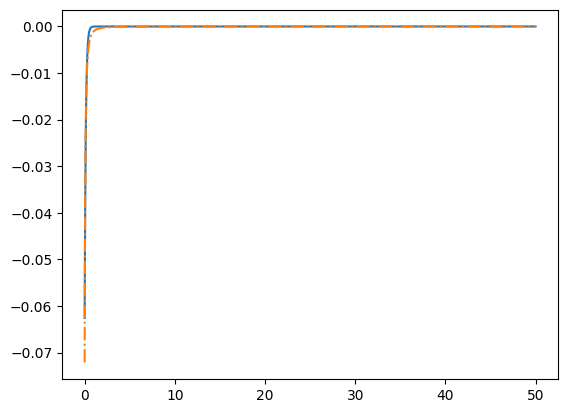

In [177]:
plt.plot(times2,np.real(fbath.correlation_function_approx(times2)))
plt.plot(times2,np.real(C),'-.')

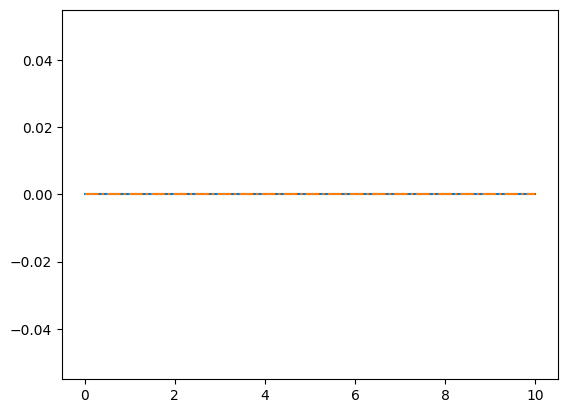

In [59]:
plt.plot(times2,np.imag(fbath.correlation_function(times2)))
plt.plot(times2,np.imag(C),'-.')

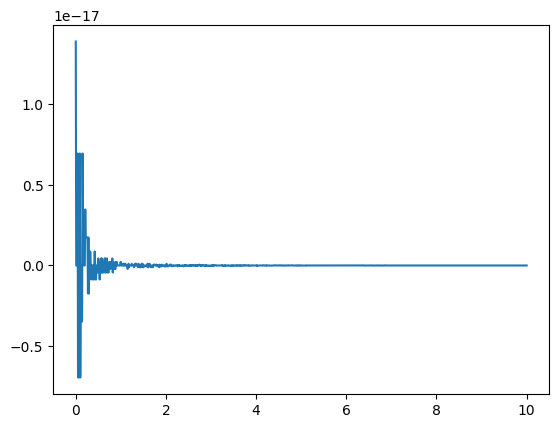

In [61]:
plt.plot(times2,np.real(C)-np.real(fbath.correlation_function(times2))) #negligeable error
plt.show()

Reproducing the full correlation function

In [62]:
def C0(t,coupling,gamma,w0,beta=np.inf):
    Gamma= gamma/2
    Omega= np.sqrt(w0**2 -Gamma**2 +0j)
    if beta!=np.inf:
        tempc0r= (1/np.tanh(beta*(Omega+ Gamma*1j)/2))*np.exp(1j*Omega*t)
    else:
        tempc0r= np.exp(1j*Omega*t)# Tookl the limit analytically because there seems to be some issues with numpy
    c0r=tempc0r+np.conjugate(tempc0r)
    c0i= -2j*np.sin(Omega*t)
    return (coupling**2 )/(2*Omega)*np.exp(-Gamma*t)*np.exp(-1j*Omega*t)

In [63]:
bath=heom.UnderDampedBath(sz_list[-1],lam+0j,gamma+0j,w0,1e-18,5) # functions don't take zero because 1/T should be fixed

In [64]:
full=bath.correlation_function(times)

/home/mcditoos/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:425: RuntimeWarning: overflow encountered in exp
  return (1 / (np.exp(w / self.T) - 1))


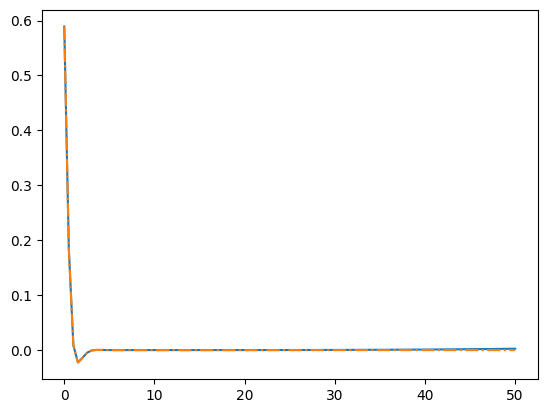

In [65]:
plt.plot(times,np.real(C0(times,lam,gamma,w0))+np.real(fbath.correlation_function(times)))
plt.plot(times,np.real(full),"-.")
plt.show()

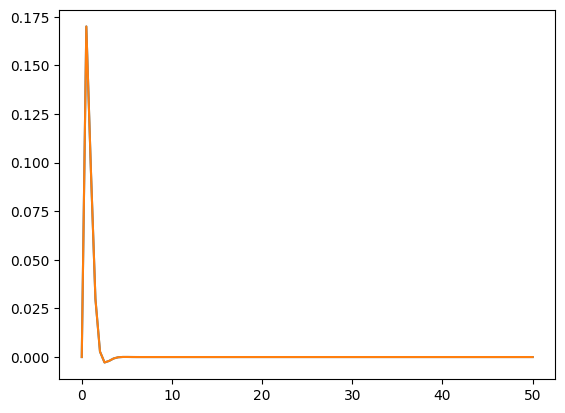

In [66]:
plt.plot(times,
         np.imag(C0(times,lam,gamma,w0))+np.imag(fbath.correlation_function(times)))
#plt.plot(times,-np.imag(full)-(np.imag(C0(times,lam,gamma,w0))+np.imag(fbath.correlation_function(times))),"-.")
plt.plot(times,np.imag(full))
plt.show()

Pseudomode equation

In [160]:
cutoff=3
def tensor_id(op,pos,cutoff=cutoff):
    if pos==0:
        return tensor([op,qeye(cutoff),qeye(cutoff)])
    if pos==1:
        return tensor([qeye(H.shape[0]),op,qeye(cutoff),])
    else:
        return tensor([qeye(H.shape[0]),qeye(cutoff),op])
Gamma= gamma/2
Omega= np.sqrt(w0**2 -Gamma**2)
Hsys=tensor_id(H,0)
Qeff=tensor_id(Q,0)
a=tensor_id(destroy(cutoff),2)
a.dims=Qeff.dims
b=tensor_id(destroy(cutoff),1)
b.dims=Qeff.dims
Hpm= Omega*a.dag()*a-finfo['params_real'][2][0]*b.dag()*b
Hsys_pm=np.sqrt(((lam**2)/(2*Omega)))*Qeff*(a+a.dag())+1j*np.sqrt(-finfo['params_real'][0][0]+0j)*Qeff*(b+b.dag())
Heff=Hsys+Hsys_pm+Hpm

In [161]:
c_ops = [np.sqrt(gamma)*a, np.sqrt(-2*finfo['params_real'][1][0]+0j)*b]
e_ops = [Hsys]

In [162]:
times = np.linspace(0, 50, 100)
c_ops = [np.sqrt(gamma)*a, np.sqrt(-2*finfo['params_real'][1][0]+0j)*b]
e_ops = [Hsys]
psi02 = tensor(psi0, basis(cutoff,0), basis(cutoff,0))
psi02 = psi02.to("CSR")

In [163]:
options ={"nsteps":1500, "store_states":True, "atol":1e-13, "rtol":1e-13}

In [164]:
pseudomode=mesolve(Heff, psi02, times, c_ops, e_ops)

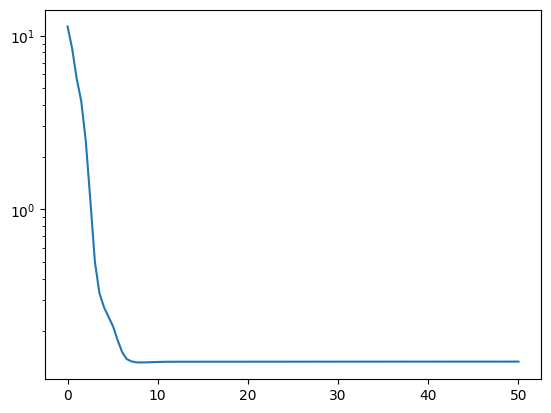

In [165]:
plt.plot(times,pseudomode.expect[0]-np.min(H.eigenenergies()))
plt.yscale("log")

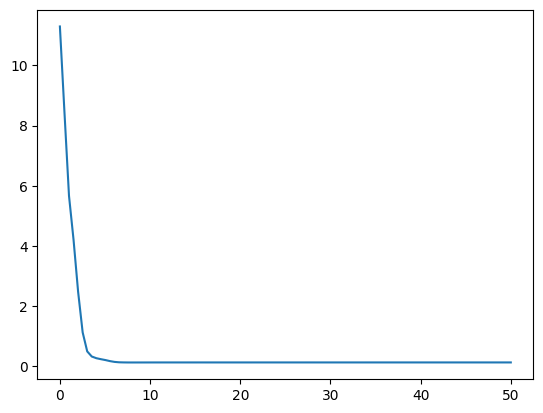

In [166]:
plt.plot(times,pseudomode.expect[0]-np.min(H.eigenenergies()))

In [168]:
-(pseudomode.expect[0][-1]-np.min(H.eigenenergies()))/np.min(H.eigenenergies()) *100

1.2934082951897055

Check if steady state is ok using heom

In [26]:
bath=heom.UnderDampedBath(Q,lam,gamma,w0,1e-18,5) # functions don't take zero because 1/T should be fixed

In [27]:
times2=np.linspace(0,10,1000)

In [38]:
cfiitter2=heom.CorrelationFitter(Q,0,times2,bath.correlation_function)
fit2=cfiitter2.get_fit(Ni=1,Nr=2)

In [39]:
print(fit2[1]['summary']) #notice one mode is also a pretty good approximation

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         | 6.68e-01 |-1.91e+00 |1.10e+01                              | 1         |-6.61e-01 |-1.90e+00 |1.10e+01                              
 2         |-7.27e-02 |-9.22e+00 |7.90e-09                              |                                                                        
                                                                        |A  normalized RM

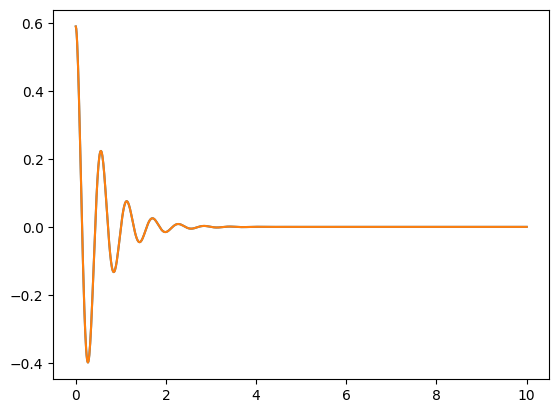

In [40]:
plt.plot(times2,np.real(bath.correlation_function(times2)))
plt.plot(times2,np.real(fit2[0].correlation_function(times2)))
plt.show()

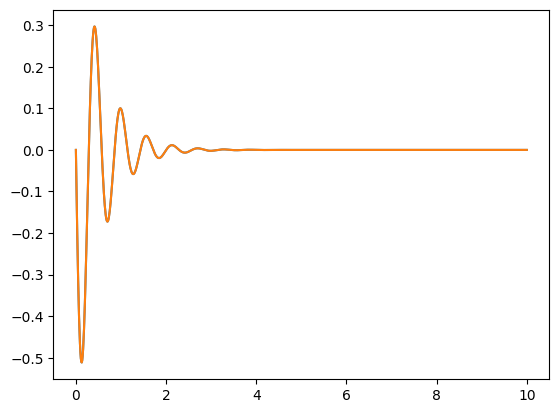

In [41]:
plt.plot(times2,np.imag(bath.correlation_function(times2)))
plt.plot(times2,np.imag(fit2[0].correlation_function(times2)))
plt.show()

In [42]:
solver = heom.HEOMSolver(H,
                    [fit2[0]], max_depth=3,options={"atol":1e-4})
result = solver.run(psi0*psi0.dag(), times)

10.1%. Run time:   0.22s. Est. time left: 00:00:00:01
20.2%. Run time:   0.44s. Est. time left: 00:00:00:01
30.3%. Run time:   0.69s. Est. time left: 00:00:00:01
40.4%. Run time:   0.90s. Est. time left: 00:00:00:01
50.5%. Run time:   1.11s. Est. time left: 00:00:00:01
60.6%. Run time:   1.34s. Est. time left: 00:00:00:00
70.7%. Run time:   1.58s. Est. time left: 00:00:00:00
80.8%. Run time:   1.80s. Est. time left: 00:00:00:00
90.9%. Run time:   2.11s. Est. time left: 00:00:00:00
100.0%. Run time:   2.33s. Est. time left: 00:00:00:00
Total run time:   2.33s


In [43]:
sdd=[(i*H).tr() for i in result.states]

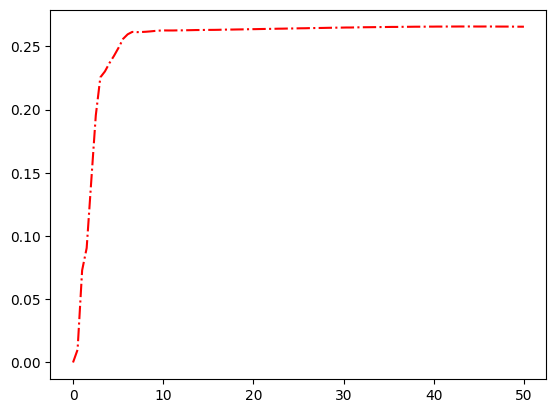

In [44]:
plt.plot(times, pseudomode.expect[0]-sdd,"-.", color="r")
plt.show()# Add master equations to the miz and show this ones in your thesis

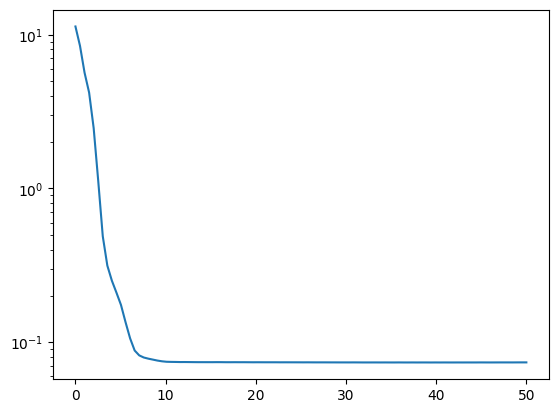

In [45]:
plt.plot(times,sdd-np.min(H.eigenenergies()))
plt.yscale("log")

In [48]:
-(sdd[-1]-np.min(H.eigenenergies()))/np.min(H.eigenenergies()) *100

(0.7182698884208608+1.959176397924203e-11j)

In [49]:
np.min(H.eigenenergies())

-10.288889346122119

In [140]:
sdd[-1]

(-10.214987352095982+2.015774916777624e-12j)

In [141]:
pseudomode.expect[0][-1]

-10.155813272394429